# End-to-End ML Project: Intial investigation

We're looking at the California Housing Prices (1990) dataset from the StatLib repository.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from download_datasets import fetch_housing_data, load_housing_data
from distance_to_ocean import distance_to_coast

# Inspect the data

In [22]:
housing = load_housing_data()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [23]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [24]:
# Let's encode `ocean_proximity`
op_encoder = OneHotEncoder()
op_1hot = op_encoder.fit_transform(housing[['ocean_proximity']])
housing = pd.merge(
    housing,
	pd.DataFrame(op_1hot.toarray(), columns=list(op_encoder.categories_[0]), dtype=int),
    left_index=True,
    right_index=True
)

In [25]:
# we can also just calculate the distance to the ocean
housing['ocean_distance_km'] = housing.apply(
    lambda _: distance_to_coast(_['longitude'], _['latitude']),
    axis=1
)

In [42]:
# Let's also create some more meaningful fields from those existing
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_house"] = housing["total_bedrooms"] / housing["households"]
housing["population_per_house"] = housing["population"] / housing["households"]

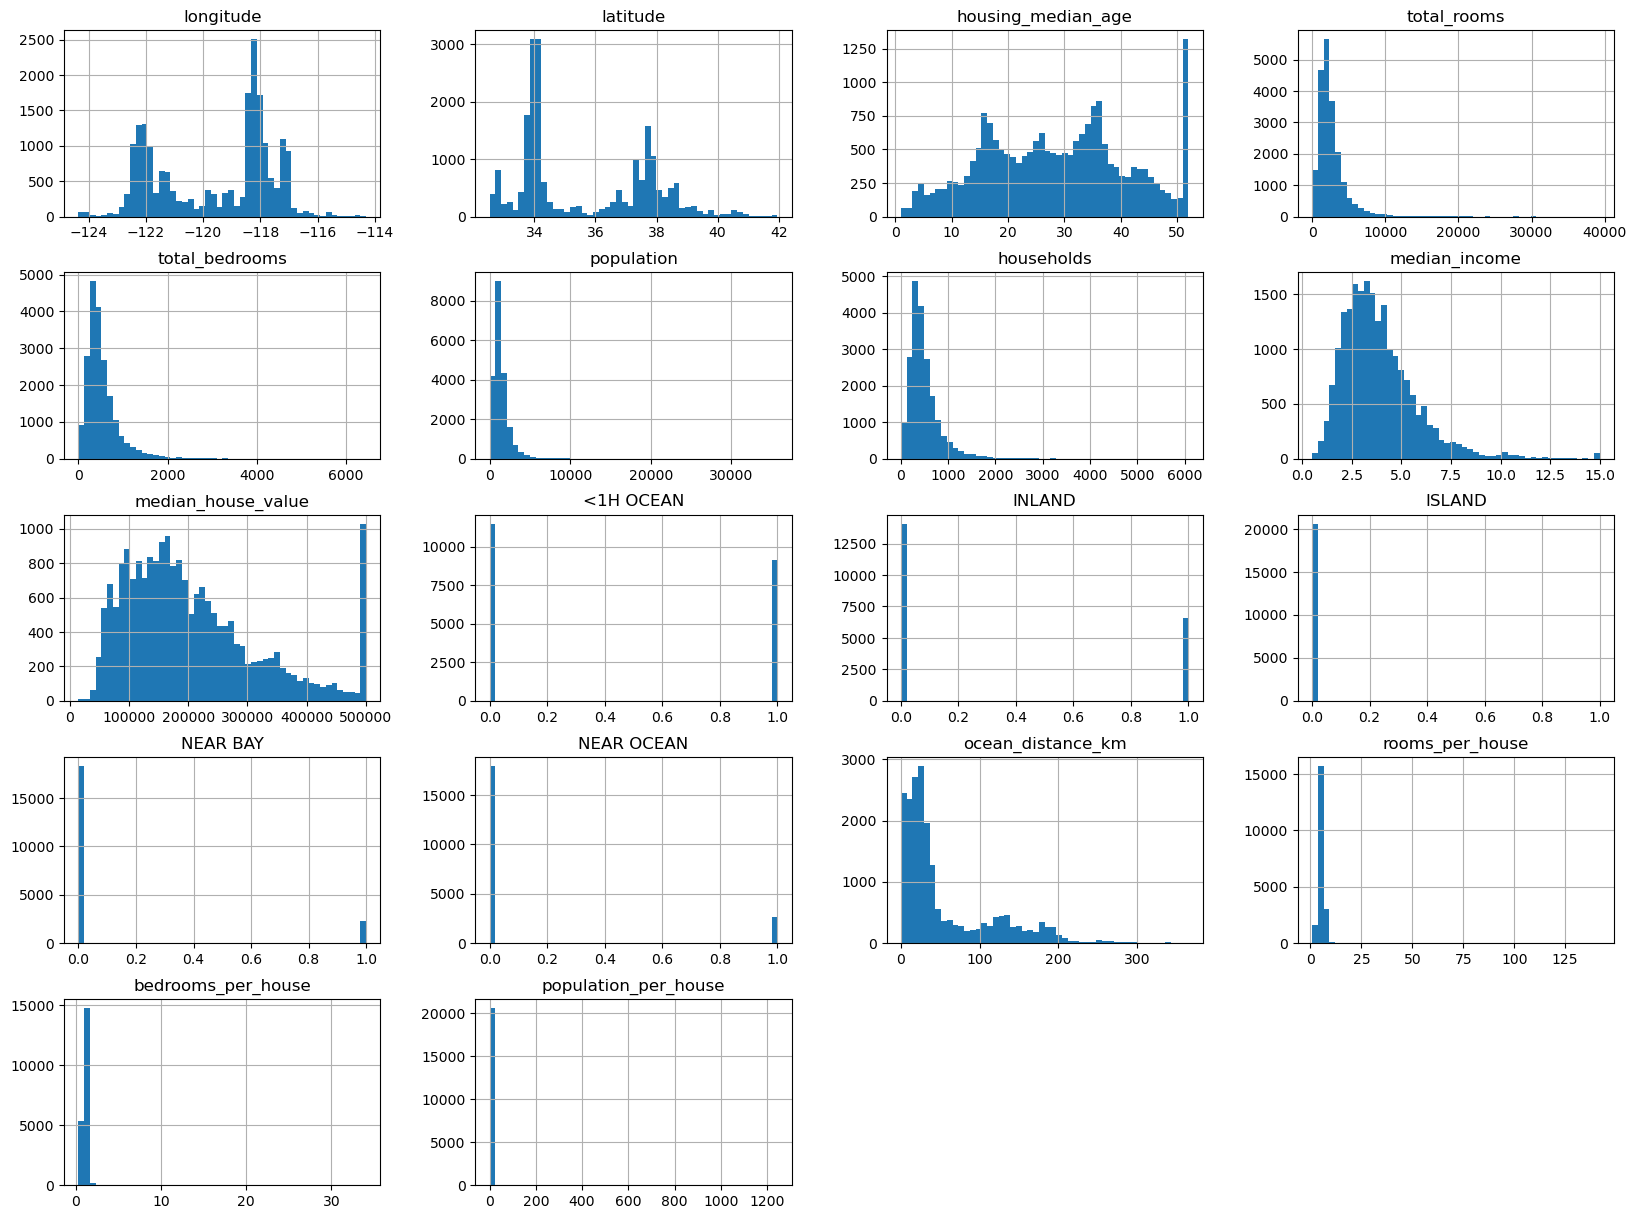

In [43]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Create a test set

In [44]:
# Naive approach
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<Axes: >

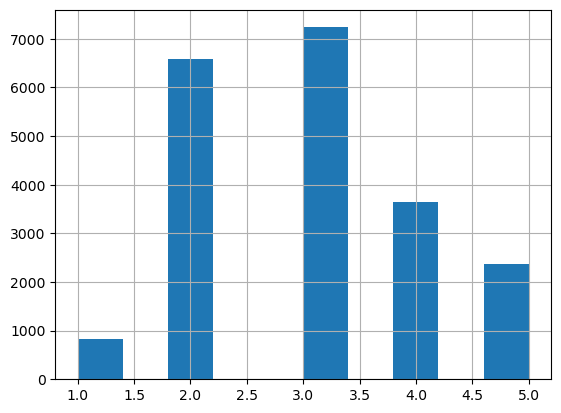

In [45]:
# Using stratified sampling.
# we first inspect median income

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0, 1.5, 3, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing["income_cat"].hist()

In [46]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

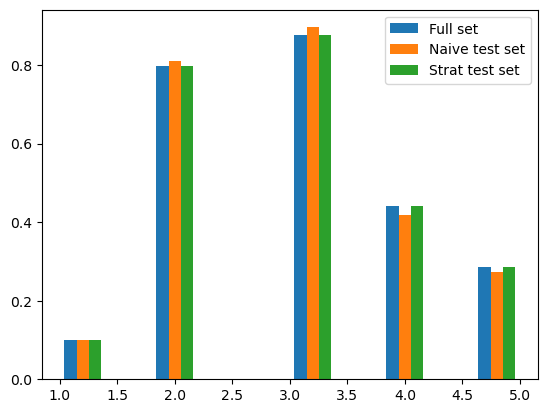

In [47]:
# Look at the proportions of incomes in the test set
# and compare to the proportions of incomes in the whole set

# We'll do the naive split again now se have the `income_cat` field
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

plt.hist(
    [
        housing["income_cat"],
        test_set["income_cat"],
        strat_test_set["income_cat"]
    ], 
    label=[
        'Full set', 
        'Naive test set',
        'Strat test set'
        ], 
    density=True
)
plt.legend(loc='upper right')
plt.show()

In [48]:
# now remove the `income_cat` field
for df in (train_set, test_set, housing):
    df.drop(columns=["income_cat"], inplace=True)

# Visualising

In [49]:
train = strat_train_set.copy()

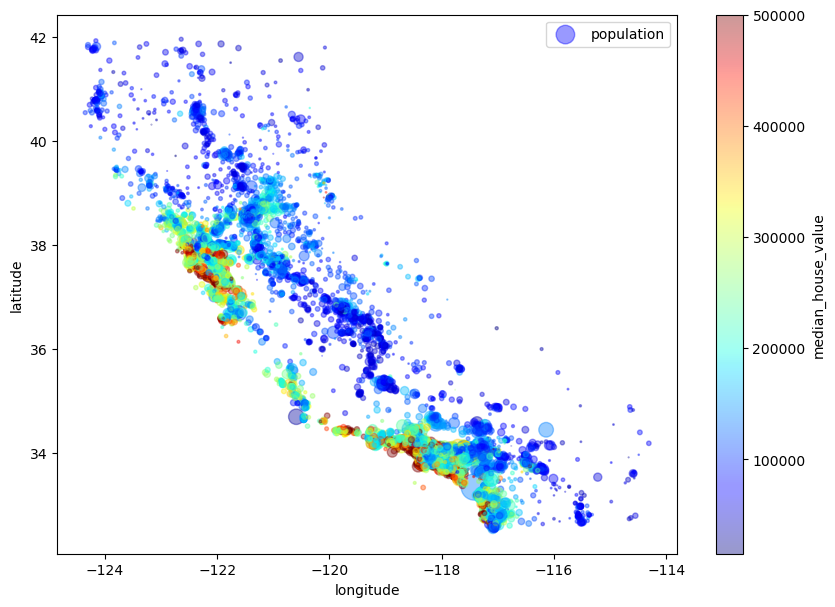

In [50]:
train.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=train["population"]/100,
    label="population",
    figsize=(10,7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True
)
plt.legend()

# Looking for correlations

In [55]:
corr_matrix = train[
    [
        'median_house_value', 
        'median_income',
        'total_rooms',
        'housing_median_age',
        'households',
        'rooms_per_house',
        'bedrooms_per_house',
        'population_per_house',
        'latitude',
        'ocean_distance_km'
    ]
].corr()

In [56]:
corr_matrix['median_house_value']

median_house_value      1.000000
median_income           0.687151
total_rooms             0.135140
housing_median_age      0.114146
households              0.064590
rooms_per_house         0.146255
bedrooms_per_house     -0.043349
population_per_house   -0.021991
latitude               -0.142673
ocean_distance_km      -0.502442
Name: median_house_value, dtype: float64

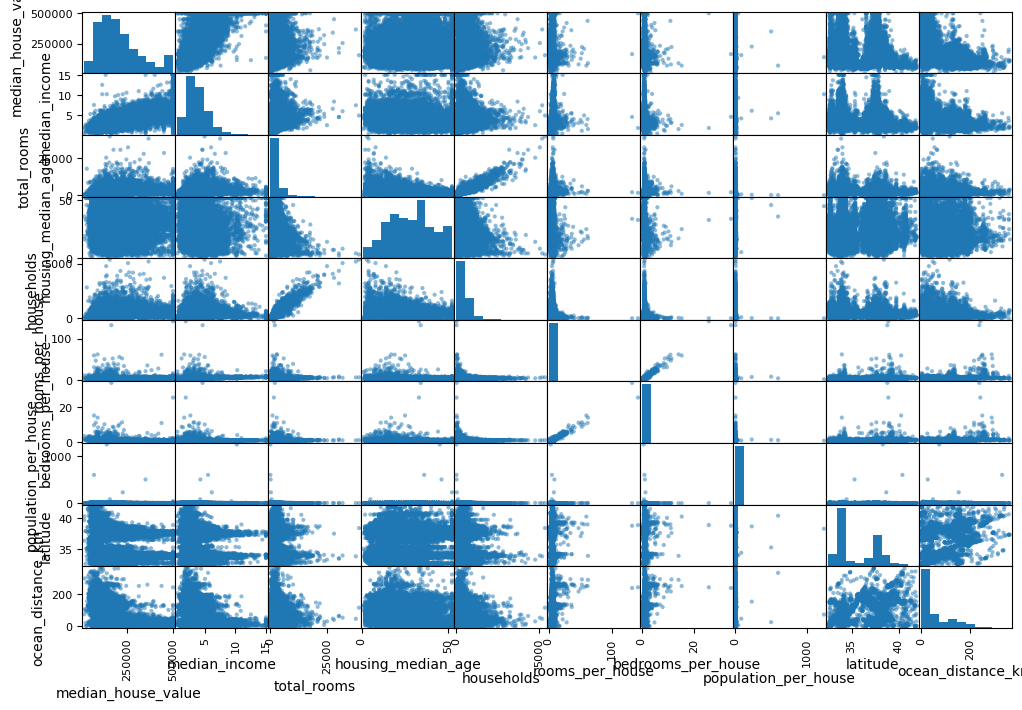

In [58]:
attrbutes = [
	'median_house_value', 
	'median_income',
	'housing_median_age',
	'households',
	'rooms_per_house',
	'bedrooms_per_house',
	'population_per_house',
	'latitude',
	'ocean_distance_km'	
]
pd.plotting.scatter_matrix(train[attrbutes], figsize=(12,8))
plt.show()

# Cleaning

In [59]:
# We'll fill missing values with the median

attrbutes = [
	'median_house_value', 
	'median_income',
	'housing_median_age',
	'households',
	'rooms_per_house',
	'bedrooms_per_house',
	'population_per_house',
	'latitude',
	'ocean_distance_km'	
]

train_numerical = train[attrbutes].copy()

In [61]:
imputer = SimpleImputer(strategy='median')
imputer.fit(train_numerical)

SimpleImputer(strategy='median')

In [62]:
X = imputer.transform(train_numerical)